In [ ]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K

from tensorflow.keras import layers

In [ ]:
# Config
INPUT_DIR = Path("/kaggle/working/output_wav2vec_precomputed_5_class")

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
NUM_CLASSES = len(LABEL_COLS)

BATCH_SIZE_PER_REPLICA = 16 # Batch size for each TPU core
EPOCHS = 150
LEARNING_RATE = 1e-5
THRESHOLD = 0.5

TRAIN_DATA_PATH = INPUT_DIR / "train_data_5_class.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data_5_class.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data_5_class.npz"
OUTPUT_DIR = Path("./output_conformer_training_tpu")
BEST_MODEL_PATH = OUTPUT_DIR / "best_conformer_model_tpu.keras"

In [ ]:

print("--- Initializing TPU Strategy ---")

try:
    # This is the robust, user-provided method for Kaggle TPU initialization
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
    # tf.config.experimental_connect_to_cluster(tpu)
    # tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print('TPU successfully initialized. Found TPU: ', tpu.master())
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    print(f"Global batch size set to: {BATCH_SIZE}")
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"⚠️ TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA

--- Initializing TPU Strategy ---
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1753155619.680128      10 service.cc:148] XLA service 0x591aeb45cbf0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753155619.680171      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1753155619.680175      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1753155619.680178      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1753155619.680181      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1753155619.680184      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1753155619.680186      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1753155619.680189      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1753155619.680192      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [ ]:

print("\n--- Loading all compressed features into RAM... ---")

# Load the compressed .npz files
train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

# Access the arrays by the keys we used when saving ('x' and 'y')
X_train, y_train = train_data['x'], train_data['y']
X_val, y_val = val_data['x'], val_data['y']
X_test, y_test = test_data['x'], test_data['y']

print("All compressed data loaded successfully.")
print(f"X_train shape: {X_train.shape}")


--- Loading all compressed features into RAM... ---
All compressed data loaded successfully.
X_train shape: (28187, 150, 768)


In [65]:
print(f"y_train shape: {y_train.shape}")

y_train shape: (28187, 5)


In [11]:
print("\n--- Verifying final training set distribution after augmentation... ---")

# Convert the y_train numpy array to a pandas DataFrame to easily count labels
final_train_labels_df = pd.DataFrame(y_train, columns=LABEL_COLS)

print("Final distribution of labels in the training set (including augmented samples):")
print(final_train_labels_df.sum().sort_values(ascending=False))


--- Verifying final training set distribution after augmentation... ---
Final distribution of labels in the training set (including augmented samples):
Block           10848
Interjection    10824
Prolongation    10800
SoundRep        10038
WordRep          9346
dtype: int64


In [ ]:

print("\n--- Building tf.data pipeline... ---")

def prepare_dataset(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True)
val_dataset = prepare_dataset(X_val, y_val)
test_dataset = prepare_dataset(X_test, y_test)
print("Datasets created successfully.")


--- Building tf.data pipeline... ---
Datasets created successfully.


In [ ]:
with strategy.scope():
    print("\nBuilding Transformer Model")
    # Transformer Encoder Block 
    def transformer_encoder(x, num_heads=4, ff_dim=128, dropout=0.1):
        # Attention and Normalization
        x_attn = layers.LayerNormalization(epsilon=1e-6)(x)
        x_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=EMBEDDING_DIM // num_heads)(x_attn, x_attn)
        x_attn = layers.Dropout(dropout)(x_attn)
        x = x + x_attn # Residual connection

        # Feed Forward Network
        x_ff = layers.LayerNormalization(epsilon=1e-6)(x)
        x_ff = layers.Dense(ff_dim, activation="relu")(x_ff)
        x_ff = layers.Dropout(dropout)(x_ff)
        x_ff = layers.Dense(EMBEDDING_DIM)(x_ff)
        x = x + x_ff # Residual connection
        
        return x

    def build_transformer_classifier(input_shape, num_classes):
        inputs = layers.Input(shape=input_shape)
        x = inputs
        
        # Apply one or more Transformer encoder blocks
        x = transformer_encoder(x, num_heads=4, ff_dim=256)
        x = transformer_encoder(x, num_heads=4, ff_dim=256)
        
        # Pool the sequence to a single vector
        x = layers.GlobalAveragePooling1D()(x)
        
        # Classifier head
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='sigmoid')(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc', multi_label=True)]
        )
        return model

    model = build_transformer_classifier(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)

print(f"LEARNING RATE: {LEARNING_RATE}")
print(f"BATCH SIZE: {BATCH_SIZE}")


Building Transformer Model


Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 150, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ input_layer_30[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 150, 768)  │  2,362,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 150, 768)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 150, 768)  │          0 │ input_layer_30[0… │
│                     │                   │            │ dropout_44[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 150, 256)  │    196,864 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 150, 256)  │          0 │ dense_65[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 150, 768)  │    197,376 │ dropout_45[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 150, 768)  │          0 │ add_9[0][0],      │
│                     │                   │            │ dense_66[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 150, 768)  │  2,362,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 150, 768)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 150, 768)  │          0 │ add_10[0][0],     │
│                     │                   │            │ dropout_47[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_11[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_67 (Dense)    │ (None, 150, 256)  │    196,864 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 150, 256)  │          0 │ dense_67[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 150, 768)  │    197,376 │ dropout_48[0][0]

 Total params: 5,618,437 (21.43 MB)

 Trainable params: 5,618,437 (21.43 MB)

 Non-trainable params: 0 (0.00 B)

NameError: name 'learning_rate' is not defined

In [77]:
print("\n--- Starting Training on TPU... ---")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


--- Starting Training on TPU... ---
Epoch 1/150


I0000 00:00:1753167409.729339      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:11679656839412793526
I0000 00:00:1753167410.907036     946 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16899944167862437409), session_name()
I0000 00:00:1753167423.614434     946 tpu_compile_op_common.cc:245] Compilation of 16899944167862437409 with session name  took 12.707242717s and succeeded
I0000 00:00:1753167423.662441     946 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16899944167862437409), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_11679656839412793526", property.function_library_fingerprint = 1043576117594234975, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap

220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2522 - auc: 0.5559 - loss: 0.6754 - precision: 0.4513 - recall: 0.2283

I0000 00:00:1753167433.229076     935 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(18051012044886479341), session_name()
I0000 00:00:1753167444.416190     935 tpu_compile_op_common.cc:245] Compilation of 18051012044886479341 with session name  took 11.187043056s and succeeded
I0000 00:00:1753167444.456900     935 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(18051012044886479341), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_11679656839412793526", property.function_library_fingerprint = 1043576117594234975, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,150,768,;4,5,;", property.guaranteed_constants_size = 0, embedding_

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.2522 - auc: 0.5561 - loss: 0.6753 - precision: 0.4515 - recall: 0.2282

I0000 00:00:1753167461.263237      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:15502783506260150662
I0000 00:00:1753167461.708314     933 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16721857641164932696), session_name()
I0000 00:00:1753167463.874470     933 tpu_compile_op_common.cc:245] Compilation of 16721857641164932696 with session name  took 2.166101812s and succeeded
I0000 00:00:1753167463.881272     933 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16721857641164932696), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_15502783506260150662", property.function_library_fingerprint = 7934316245141058141, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap(


Epoch 1: val_auc improved from -inf to 0.68144, saving model to output_conformer_training_tpu/best_conformer_model_tpu.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - accuracy: 0.2522 - auc: 0.5563 - loss: 0.6752 - precision: 0.4517 - recall: 0.2281 - val_accuracy: 0.2035 - val_auc: 0.6814 - val_loss: 0.6439 - val_precision: 0.5406 - val_recall: 0.2625
Epoch 2/150
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2957 - auc: 0.6367 - loss: 0.6249 - precision: 0.5551 - recall: 0.2775
Epoch 2: val_auc improved from 0.68144 to 0.69051, saving model to output_conformer_training_tpu/best_conformer_model_tpu.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.2955 - auc: 0.6368 - loss: 0.6249 - precision: 0.5552 - recall: 0.2775 - val_accuracy: 0.2114 - val_auc: 0.6905 - val_loss: 0.6097 - val_precision: 0.6445 - val_recall: 0.3124
Epoch 3/150
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3138 - auc: 0.6628 - loss: 0.6080 - precision: 0.6009 - recall: 0.3301



--- Evaluating Model on the Test Set ---


I0000 00:00:1753168574.958588      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:17697821599832892566
E0000 00:00:1753168575.026219      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_28_1/dense_65_1/BiasAdd/ReadVariableOp.
I0000 00:00:1753168575.182894     898 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(12073068635376582140), session_name()
I0000 00:00:1753168576.966740     898 tpu_compile_op_common.cc:245] Compilation of 12073068635376582140 with session name  took 1.78378997s and succeeded
I0000 00:00:1753168576.971991     898 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(12073068635376582140), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_17697821599832892566", property.function_library_fingerprint = 5505394554771044682, property.mlir_module_fin

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

I0000 00:00:1753168582.564442      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:13361647731504148461
I0000 00:00:1753168582.917469     960 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(11941636207443383809), session_name()
I0000 00:00:1753168584.368679     960 tpu_compile_op_common.cc:245] Compilation of 11941636207443383809 with session name  took 1.451159037s and succeeded
I0000 00:00:1753168584.373204     960 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(11941636207443383809), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_13361647731504148461", property.function_library_fingerprint = 12224534912620365663, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, t

55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 202ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.66      0.44      0.53      2613
       Block       0.62      0.43      0.51      3501
    SoundRep       0.61      0.46      0.53      1891
     WordRep       0.55      0.39      0.45      1742
Interjection       0.88      0.57      0.69      3344

   micro avg       0.68      0.47      0.55     13091
   macro avg       0.66      0.46      0.54     13091
weighted avg       0.68      0.47      0.55     13091
 samples avg       0.60      0.49      0.50     13091


--- Generating plots for model training history... ---


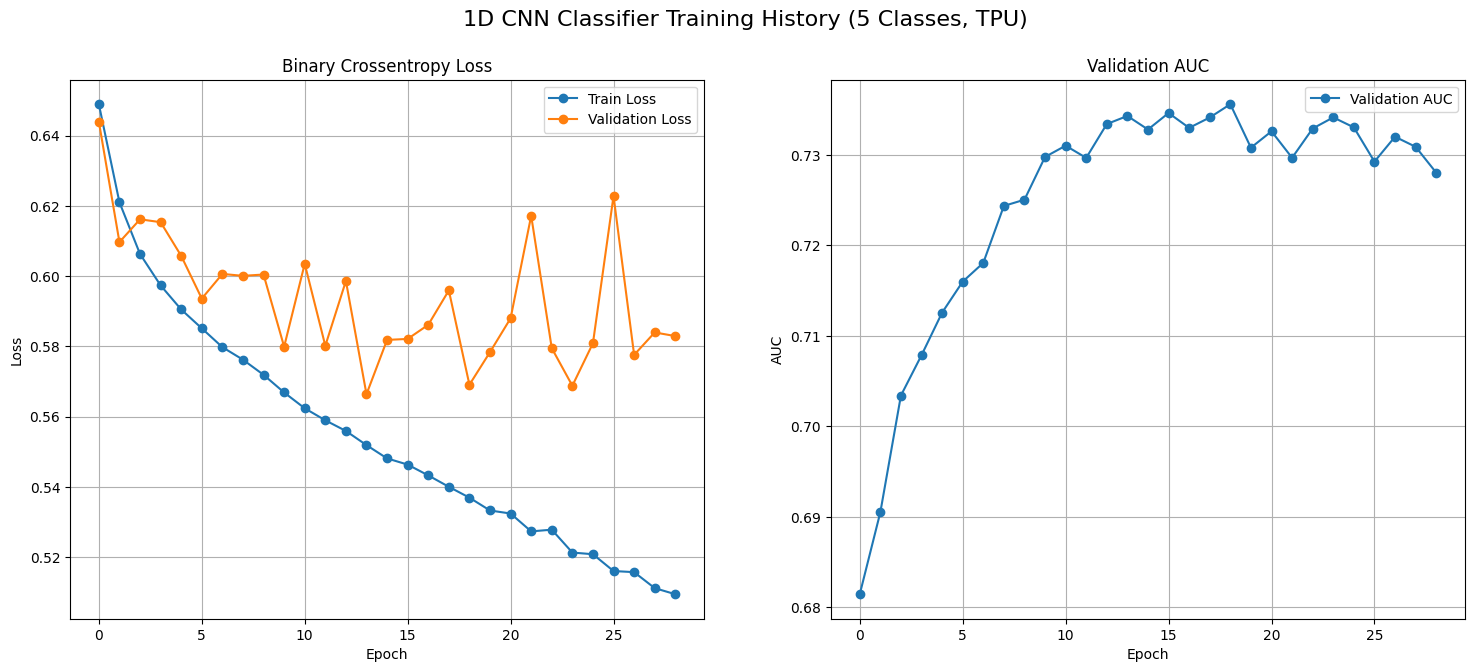


--- Pipeline complete. All outputs saved in 'output_conformer_training_tpu' directory. ---


In [ ]:

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred)
report = classification_report(y_test[:num_predictions], y_pred, target_names=LABEL_COLS, zero_division=0)
print("\n--- Classification Report (5 Stuttering Classes) ---")
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

# --- Plotting History ---
print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('1D CNN Classifier Training History (5 Classes, TPU)', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history_1d_cnn_5_class_tpu.png")
plt.show()

print(f"\n--- Pipeline complete. All outputs saved in '{OUTPUT_DIR}' directory. ---")